# Convert the binary and categorical feature space
- Fuse categoricies for each feature into smaller number of categories based on conditional probabilities
- Calculate how much edge each category value has over the bulk frequency of class1
- Replace the category value with those ratios to inflate the differeces in conditional probabilities

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm

from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

In [36]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [37]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[:-1]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = train[categorical_fs]
others = train[other_fs[1:-1]]

new_categoricals = ps.fuseCategoricalFeatures(categoricals)

bincats = pd.concat([binaries, new_categoricals], axis=1)
target = train.target

In [38]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

In [39]:
bincat2probas = {}
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    bincat2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

In [40]:
bincat2probas['ps_car_03_cat']

{0: -10.263633402873607, 1: 8.478205372761982, 2: 32.513247918634434}

In [41]:
bincat_converted = pd.DataFrame()
for i, f in enumerate(bincats.columns):
    bincat_converted[f] = bincats[f].replace(bincat2probas[f])

In [42]:
bincat_converted.head(5)

,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat
0,0.094183,0.246950,-0.078457,-0.180291,0.656528,14.095330,29.912302,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,23.282374,-3.261944,0.043887,8.665033,4.171961,6.025876,-7.085708
1,0.094183,0.246950,-0.078457,-0.180291,-1.224514,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,-1.983385,-4.546991,-7.085708
2,0.094183,0.246950,-0.078457,-0.180291,-1.224514,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-11.434986,11.888150,6.025876,-7.085708
3,0.094183,-0.416609,0.097528,-0.180291,0.656528,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,24.500160,-1.983385,-4.546991,-7.085708
4,0.094183,-0.416609,0.097528,0.447503,-1.224514,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,4.171961,6.025876,-7.085708


In [43]:
class1_freq = np.sum(target)/len(target)
class1_freq

0.036447517859182946

## Take a look at continuous/ordinal features

In [44]:
others.shape

(595212, 26)

In [45]:
others2 = others.copy()
for i, f in enumerate(others2.columns):
    data = others2[f]
    print('%s: %d unique vals' % (f, len(data.unique())))

ps_calc_01: 10 unique vals
ps_calc_02: 10 unique vals
ps_calc_03: 10 unique vals
ps_calc_04: 6 unique vals
ps_calc_05: 7 unique vals
ps_calc_06: 11 unique vals
ps_calc_07: 10 unique vals
ps_calc_08: 11 unique vals
ps_calc_09: 8 unique vals
ps_calc_10: 26 unique vals
ps_calc_11: 20 unique vals
ps_calc_12: 11 unique vals
ps_calc_13: 14 unique vals
ps_calc_14: 24 unique vals
ps_car_11: 5 unique vals
ps_car_12: 184 unique vals
ps_car_13: 70482 unique vals
ps_car_14: 850 unique vals
ps_car_15: 15 unique vals
ps_ind_01: 8 unique vals
ps_ind_03: 12 unique vals
ps_ind_14: 5 unique vals
ps_ind_15: 14 unique vals
ps_reg_01: 10 unique vals
ps_reg_02: 19 unique vals
ps_reg_03: 5013 unique vals


In [46]:
def estimate_KDE(feature, target, target_class=1, ax=None, kernel='gau', bw='normal_reference', fft=True, hist_bins='auto'):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    target_classes = feature[target == target_class]
    print(feature.shape)
    print(target_classes.shape)
    
    bulk_kde = sm.nonparametric.KDEUnivariate(feature.astype('float'))
    bulk_kde.fit(kernel=kernel, bw=bw, fft=fft)
    
    class_kde = sm.nonparametric.KDEUnivariate(target_classes.astype('float'))
    class_kde.fit(kernel=kernel, bw=bw, fft=fft)
    
    if hist_bins == 'auto':
        bins = len(feature.unique())
    elif type(hist_bins) == 'int':
        bins = hist_bins
    elif type(hist_bins == 'float'):
        bins = int(hist_bins)
    else:
        print('Error: bins must be an integer')
              
    ax.hist(feature, bins=bins, normed=True, color='skyblue', alpha=0.5, label=None)
    ax.plot(bulk_kde.support, bulk_kde.density, color='skyblue', ls='--', label='Bulk')

    ax.hist(target_classes, bins=bins, normed=True, color='red', alpha=0.2, label=None)
    ax.plot(class_kde.support, class_kde.density, color='red', alpha=0.2, ls='--', label='Target Class')
    
    ax.legend(loc='upper right')
    
    return bulk_kde, class_kde

In [47]:
def compare_KDE(kde1, kde2, span, label=None):
    density1 = kde1.evaluate(span)
    density2 = kde2.evaluate(span)
    density_ratio = density2 / density1
    plt.axhline(y=1, color='0.8', ls='--')
    plt.plot(span, density_ratio, label=label)
    plt.ylim([0, 1.1*np.max(density_ratio)])
    return

def compare_KDE2(kde1, kde2, span, label=None):
    kde1_size = len(kde1.density)
    kde2_size = len(kde2.density)
    density1 = kde1_size* kde1.evaluate(span)
    density2 = kde2_size* kde2.evaluate(span)
    cond_proba_class1_given_val = density2 / density1
    plt.axhline(y=1, color='0.8', ls='--')
    plt.plot(span, cond_proba_class1_given_val, label=label)
    plt.ylim([0, 1.1*np.max(cond_proba_class1_given_val)])
    return

def compare_KDE3(kde1, kde2, span, level=1, label=None):
    kde1_size = len(kde1.density)
    kde2_size = len(kde2.density)
    density1 = kde1_size* kde1.evaluate(span)
    density2 = kde2_size* kde2.evaluate(span)
    cond_proba_class1_given_val = density2 / density1
    percent_gain = 100*((cond_proba_class1_given_val/level) - 1)
    plt.axhline(y=1, color='0.8', ls='--')
    plt.plot(span, percent_gain, label=label)
    plt.ylabel('%% Gain from Bulk Class1 Freq')
    #plt.ylim([0, 1.1*np.max(percent_gain)])
    return

### ps_calc_04

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


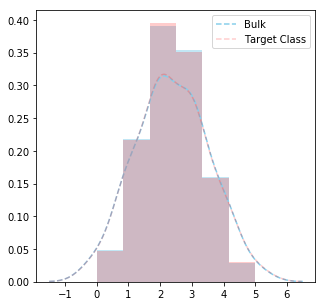

In [92]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_04'], target, target_class=1, ax=None, kernel='gau', bw=0.5, fft=True)

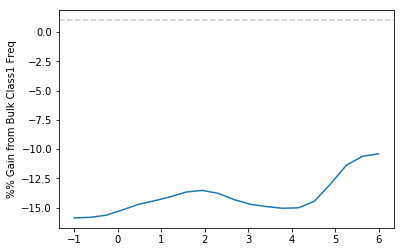

In [93]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 6, 20), level=class1_freq, label=None)

### ps_calc_05

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


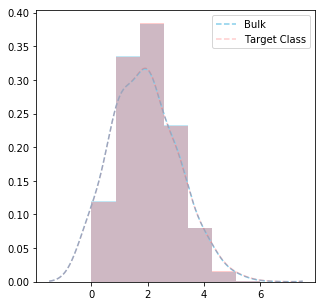

In [94]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_05'], target, target_class=1, ax=None, kernel='gau', bw=0.5, fft=True)

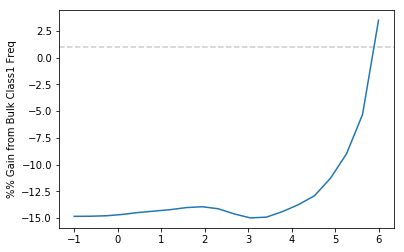

In [95]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 6, 20), level=class1_freq, label=None)

### ps_calc_06

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


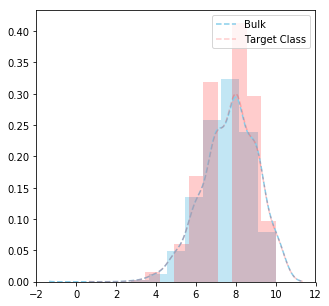

In [96]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_06'], target, target_class=1, ax=None, kernel='gau', bw=0.45, fft=True)

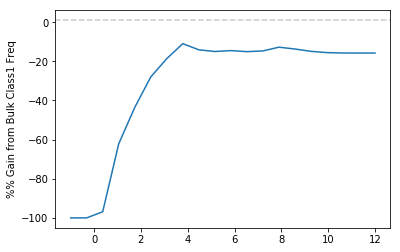

In [97]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 12, 20), level=class1_freq, label=None)

### ps_calc_07

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


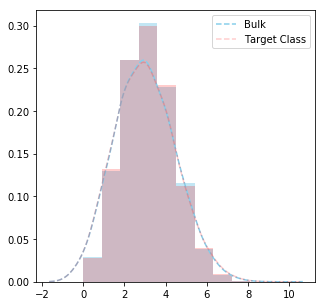

In [98]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_07'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

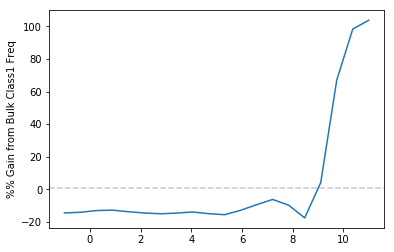

In [99]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 11, 20), level=class1_freq, label=None)

### ps_calc_08

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


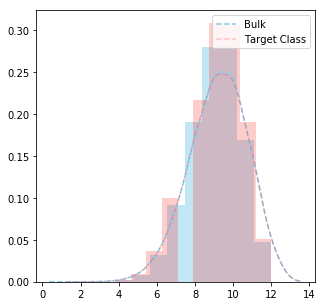

In [100]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_08'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

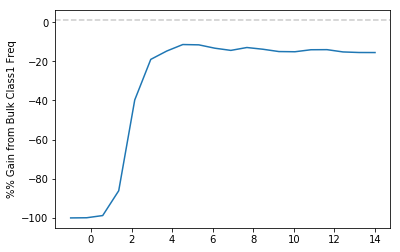

In [101]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 14, 20), level=class1_freq, label=None)

### ps_calc_09

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


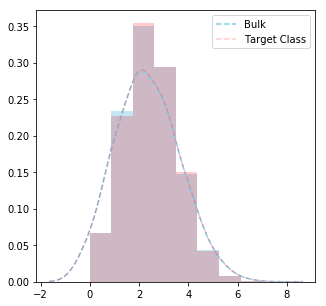

In [102]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_09'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

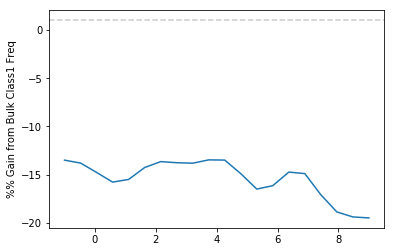

In [103]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 9, 20), level=class1_freq, label=None)

### ps_calc_10

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


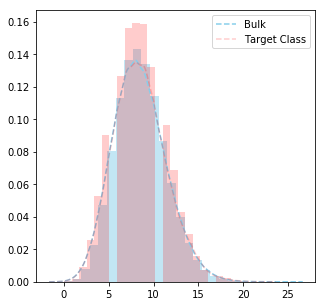

In [104]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_10'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

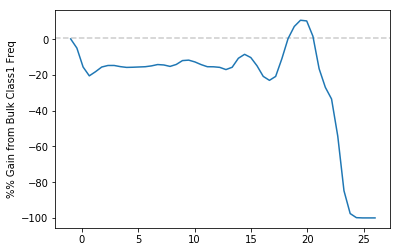

In [106]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 26, 50), level=class1_freq, label=None)

### ps_calc_11

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


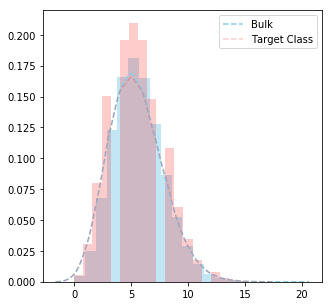

In [107]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_11'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

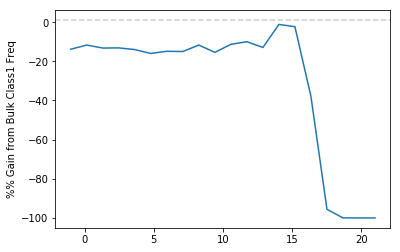

In [108]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 21, 20), level=class1_freq, label=None)

### ps_calc_12

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


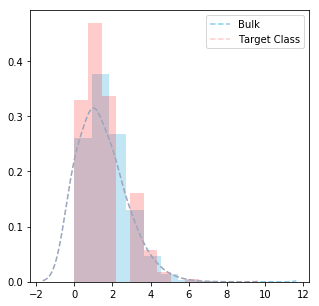

In [109]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_12'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

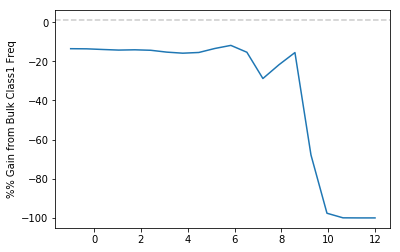

In [110]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 12, 20), level=class1_freq, label=None)

### ps_calc_13

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


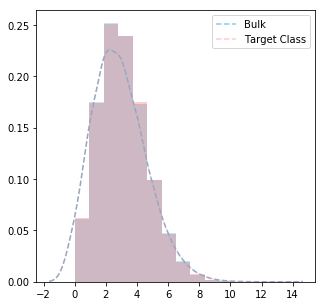

In [111]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_13'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

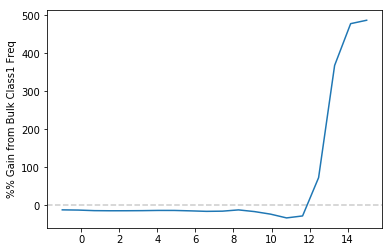

In [112]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 15, 20), level=class1_freq, label=None)

### ps_calc_14

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


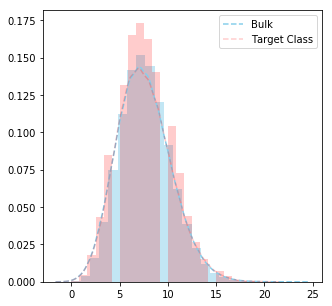

In [113]:
bulkKDE, classKDE = estimate_KDE(others2['ps_calc_14'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

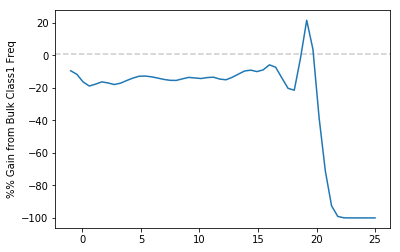

In [114]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 25, 50), level=class1_freq, label=None)

### ps_car_11

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


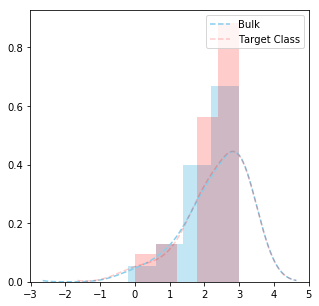

In [115]:
bulkKDE, classKDE = estimate_KDE(others2['ps_car_11'], target, target_class=1, ax=None, kernel='gau', bw=0.55, fft=True)

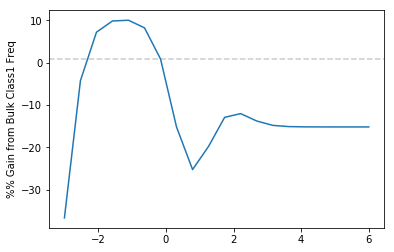

In [116]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-3, 6, 20), level=class1_freq, label=None)

### ps_car_12

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


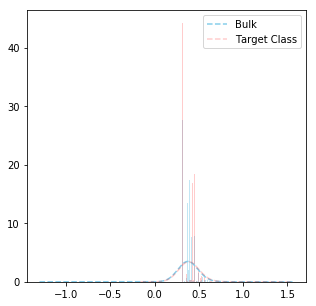

In [74]:
bulkKDE, classKDE = estimate_KDE(others2['ps_car_12'], target, target_class=1, ax=None, kernel='gau', bw=0.1, fft=True)

/home/ryohayama/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


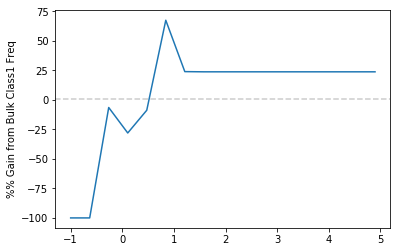

In [75]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 6, 20), level=class1_freq, label=None)

### ps_car_13

In [76]:
if False:
    estimate_KDE(others2['ps_car_13'], target, target_class=1, ax=None, kernel='gau', bw=0.2, fft=True)

### ps_car_14

(552592,)
(19971,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


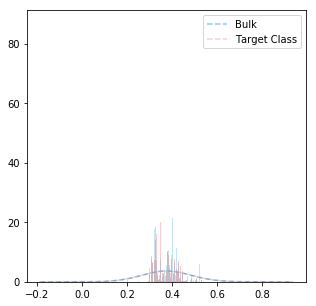

In [117]:
bulkKDE, classKDE = estimate_KDE(others2['ps_car_14'].replace({-1:np.NaN}).dropna(), target, target_class=1, ax=None, kernel='gau', bw=0.1, fft=True)

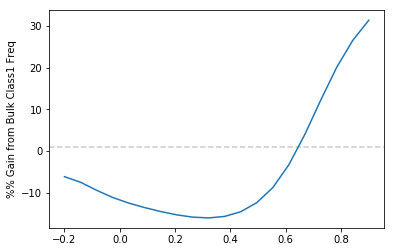

In [118]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-0.2, 0.9, 20), level=class1_freq, label=None)

### ps_car_15

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


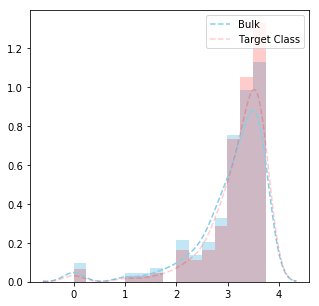

In [119]:
bulkKDE, classKDE = estimate_KDE(others2['ps_car_15'], target, target_class=1, ax=None, kernel='gau', bw=0.2, fft=True)

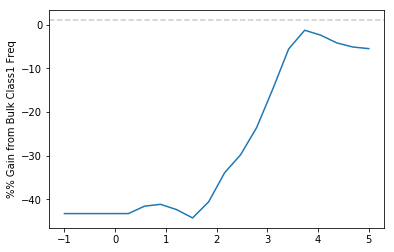

In [120]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 5, 20), level=class1_freq, label=None)

### ps_ind_01

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


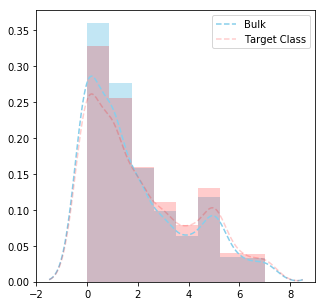

In [121]:
bulkKDE, classKDE = estimate_KDE(others2['ps_ind_01'], target, target_class=1, ax=None, kernel='gau', bw=0.5, fft=True)

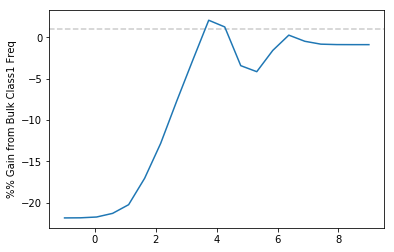

In [122]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 9, 20), level=class1_freq, label=None)

### ps_ind_03

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


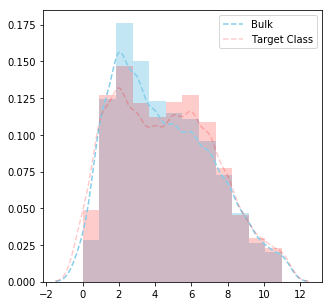

In [123]:
bulkKDE, classKDE = estimate_KDE(others2['ps_ind_03'], target, target_class=1, ax=None, kernel='gau', bw=0.5, fft=True)

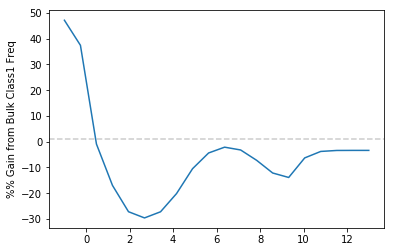

In [124]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 13, 20), level=class1_freq, label=None)

### ps_reg_01

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


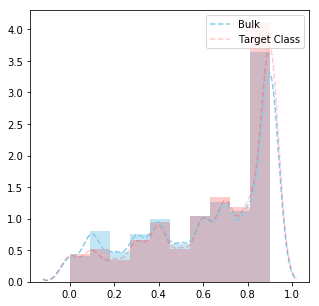

In [125]:
bulkKDE, classKDE = estimate_KDE(others2['ps_reg_01'], target, target_class=1, ax=None, kernel='gau', bw=0.04, fft=True)

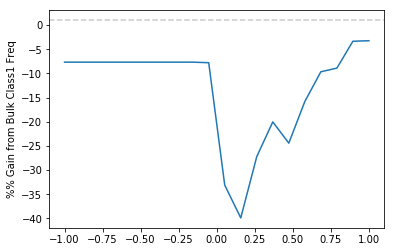

In [126]:
compare_KDE3(bulkKDE, classKDE, np.linspace(-1, 1, 20), level=class1_freq, label=None)

### ps_reg_02

(595212,)
(21694,)


/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


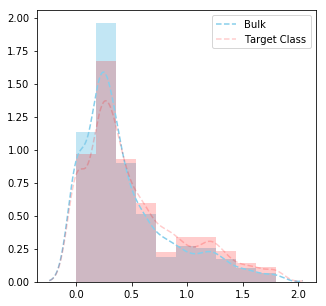

In [127]:
bulkKDE, classKDE = bulkKDE, class1KDE = estimate_KDE(others2['ps_reg_02'], target, target_class=1, ax=None, kernel='gau', bw=0.08, fft=True, hist_bins=10)

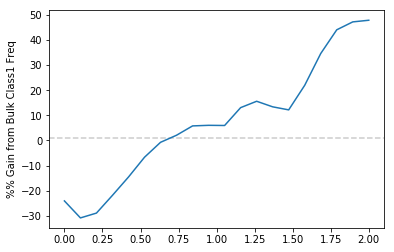

In [128]:
compare_KDE3(bulkKDE, classKDE, np.linspace(0, 2, 20), level=class1_freq, label=None)

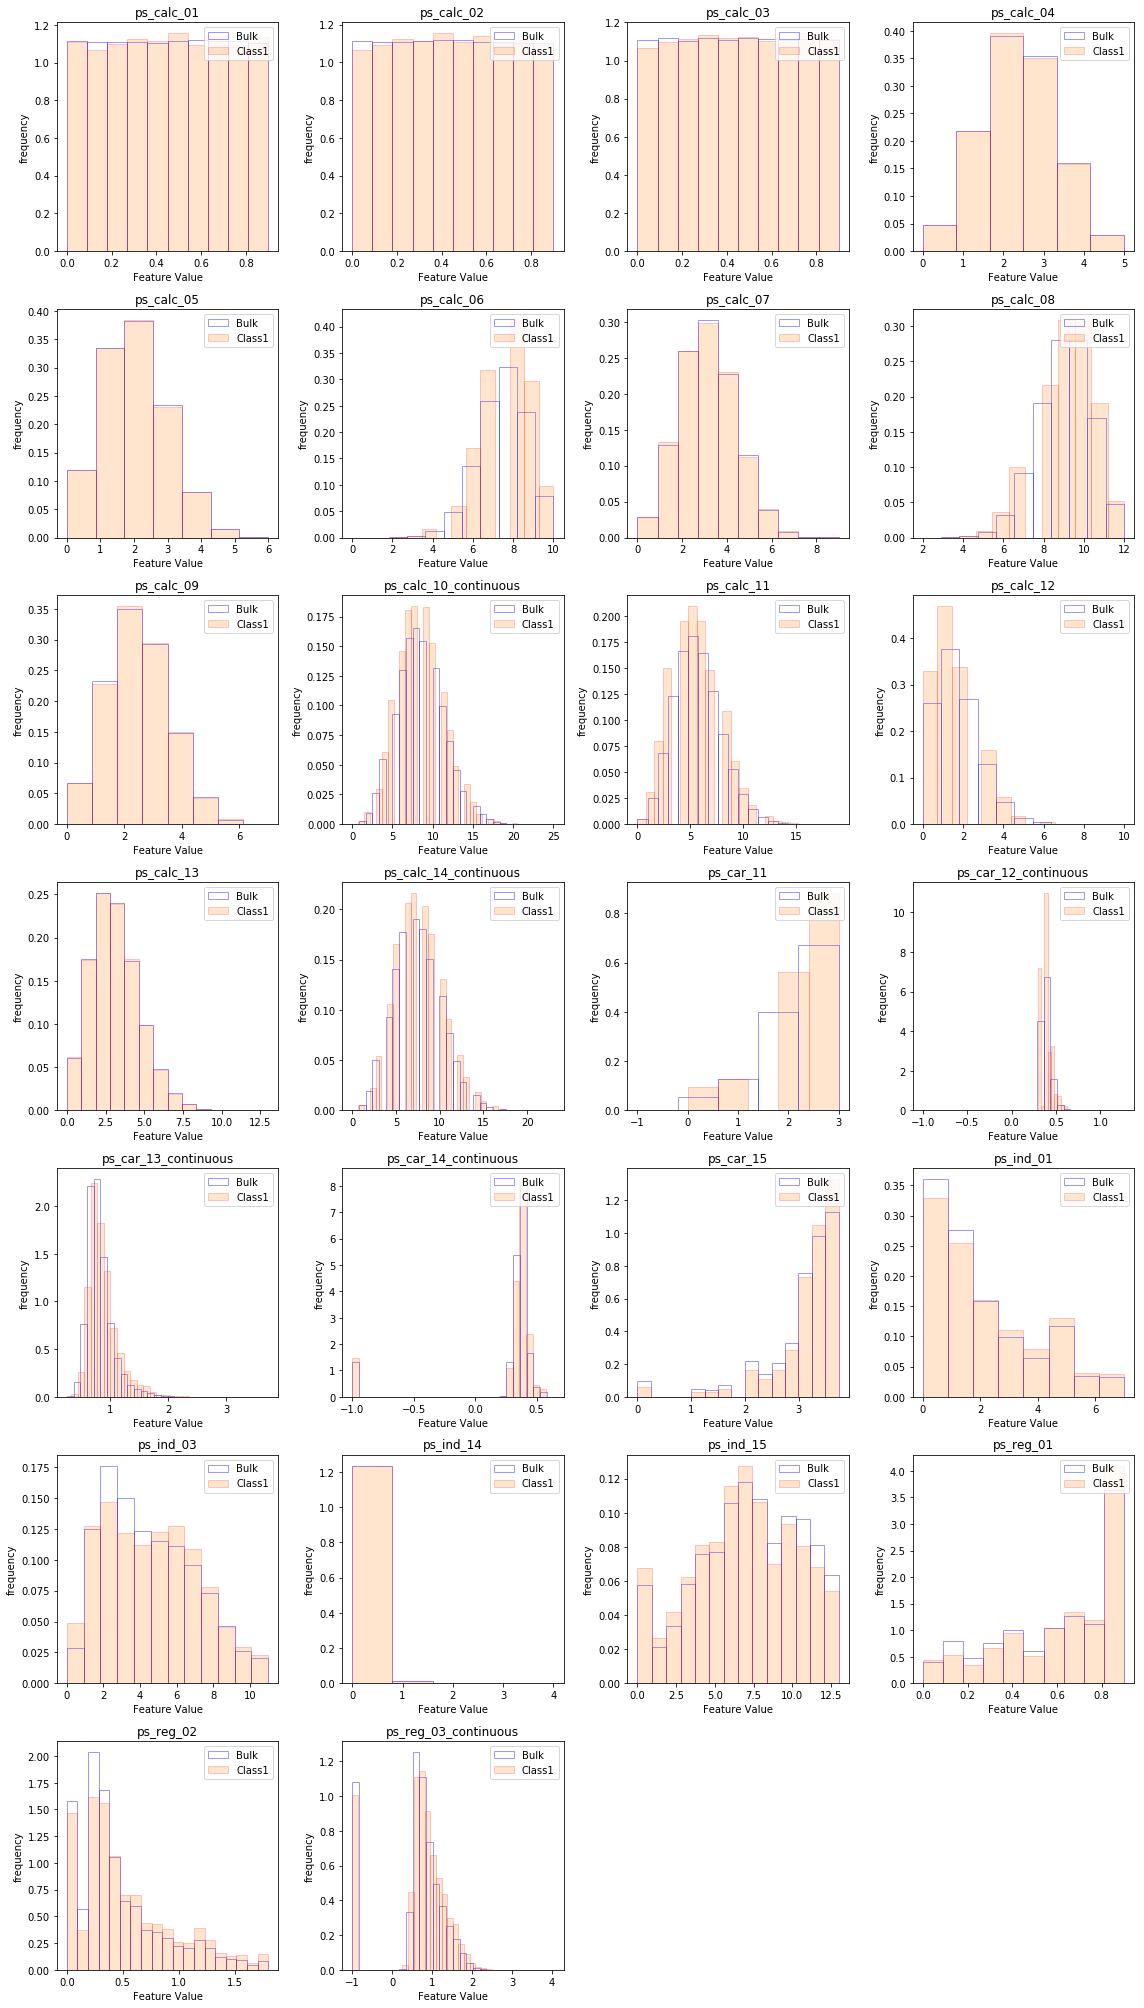

In [95]:
fig = plt.figure(figsize=(16, 28))
for i, f in enumerate(others2.columns):
    ax = fig.add_subplot(7, 4, i+1)
    data = others2[f]
    class0s = data
    class1s = data[target == 1]
    if len(data.unique()) > 20:
        bins = 30
        f = f + '_continuous'
    else:
        bins = len(data.unique())
    ax.hist(class0s, bins=bins, normed=True, edgecolor='b', alpha=0.4, fill=False, label='Bulk')
    ax.hist(class1s, bins=bins, normed=True, edgecolor='r', alpha=0.2, fill=True, label='Class1')
    ax.set_title('%s' % f)
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('frequency')
    ax.legend(loc='upper right')

plt.tight_layout()

## Digitized them before conditional probability analysis

In [ ]:
others.loc[:, 'ps_car_12'] = bin_myFeature(others.loc[:, 'ps_car_12'], 0, 1.5, bins=20)[1]
others.loc[:, 'ps_car_13'] = bin_myFeature(others.loc[:, 'ps_car_13'], 0, 4, bins=50)[1]
others.loc[:, 'ps_car_13'] = bin_myFeature(others.loc[:, 'ps_car_13'], 0, 4, bins=50)[1]
others.loc[:, 'ps_car_14'] = bin_myFeature(others.loc[:, 'ps_car_14'], 0, 4, bins=40)[1]
others.loc[:, 'ps_reg_03'] = bin_myFeature(others.loc[:, 'ps_reg_03'], 0, 5, bins=50)[1]

<b>Conditional Probas and deviations</b>

In [ ]:
for i, f in enumerate(others.columns):
    fvt = fa.FeatureVsTarget(others[f], target)
    print('==== %s ====' % f)
    print(fvt.contingency_table_)
    print(fvt.conditional_probas_)
    print(100*(fvt.calculate_deviation(mode='ratio')[0] - 1))
    print('\n')

In [ ]:
bincat2probas = {}
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    bincat2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

In [ ]:
bincat2probas['ps_car_03_cat']

In [ ]:
bincat_converted = pd.DataFrame()
for i, f in enumerate(bincats.columns):
    bincat_converted[f] = bincats[f].replace(bincat2probas[f])

In [ ]:
bincat_converted

In [ ]:
select_other_fs = ['ps_calc_05', 'ps_calc_07', 'ps_calc_13', 'ps_calc_14',
                   'ps_car_12', 'ps_car_13', 'ps_ind_03', 'ps_ind_14', 'ps_reg_02', 'ps_reg_03']
select_others = train[select_other_fs]
select_others.loc[:, 'ps_car_12'] = bin_myFeature(select_others.loc[:, 'ps_car_12'], 0, 1.5, bins=20)[1]
select_others.loc[:, 'ps_car_13'] = bin_myFeature(select_others.loc[:, 'ps_car_13'], 0, 4, bins=50)[1]
select_others.loc[:, 'ps_reg_03'] = bin_myFeature(select_others.loc[:, 'ps_reg_03'], 0, 5, bins=50)[1]

In [ ]:
others2probas = {}
for i, f in enumerate(select_others.columns):
    fvt = fa.FeatureVsTarget(select_others[f], target)
    others2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

In [ ]:
others_converted = pd.DataFrame()
for i, f in enumerate(select_others.columns):
    others_converted[f] = select_others[f].replace(others2probas[f])

In [ ]:
converted = pd.concat([bincat_converted, others_converted], axis=1)

In [ ]:
converted.columns

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
'target' in converted.iloc[:, :-1].columns

In [ ]:
pca = PCA()
X = np.array(converted.iloc[:, :-1])
y = train.target

Xpca = pca.fit_transform(X)

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
ax1.scatter(Xpca[:, 0], Xpca[:, 1], c=y, cmap=cm.Blues, s=10)
ax2.scatter(Xpca[:, 0], Xpca[:, 2], c=y, cmap=cm.Blues, s=10)
ax3.scatter(Xpca[:, 0], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)
ax4.scatter(Xpca[:, 1], Xpca[:, 2], c=y, cmap=cm.Blues, s=10)
ax5.scatter(Xpca[:, 1], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)
ax6.scatter(Xpca[:, 2], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
plt.bar(range(Xpca.shape[1]), pca.explained_variance_ratio_)

In [ ]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca[:, :20], y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = LogisticRegression(C=1e4, penalty='l1')
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [ ]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=9, learning_rate=0.05, max_delta_step=0,
       max_depth=11, min_child_weight=4, missing=None, n_estimators=200,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))